### Instruction
1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes.

In [2]:
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')
  
soybean_large = fetch_ucirepo(id=90) 
  
X = soybean_large.data.features 
y = soybean_large.data.targets 

In [3]:
import numpy as np
from sklearn.naive_bayes import logsumexp

class StochasticBernoulliMixture:
    def __init__(self, n_components, max_iter, batch_size, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        
        # Initialize old parameters
        self.old_mu = None
        self.old_pi = None
        self.old_gamma = None
    
    def fit(self, x_binary):
        self.x = x_binary
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            # Stochastic E-step and M-step
            for _ in range(self.batch_size):
                batch_indices = self.rng.choice(len(self.x), size=self.batch_size, replace=False)
                x_batch = self.x[batch_indices]
                log_bernoullis_batch = self.get_log_bernoullis(x_batch)
                self.gamma = self.get_responsibilities(log_bernoullis_batch)
                self.get_Neff()
                self.get_mu(x_batch)
                self.get_pi()
            # Compute new log_likelihood:
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        if self.old_mu is not None:
            self.mu = self.old_mu.copy()
        if self.old_pi is not None:
            self.pi = self.old_pi.copy()
        if self.old_gamma is not None:
            self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, x_batch) / self.Neff[:,None]

        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Preprocessing
# Handling missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# One-hot encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_imputed).toarray()  # Convert to dense array

# Perform clustering
n_components = 3  # Number of clusters
max_iter = 100  # Maximum number of iterations
batch_size = 50  # Size of mini-batch

# Initialize the StochasticBernoulliMixture model
stochastic_bmm = StochasticBernoulliMixture(n_components=n_components, max_iter=max_iter, batch_size=batch_size)

# Fit the model to the binary encoded data
stochastic_bmm.fit(X_encoded)

# Extract cluster assignments
cluster_assignments = stochastic_bmm.predict(X_encoded)

nan


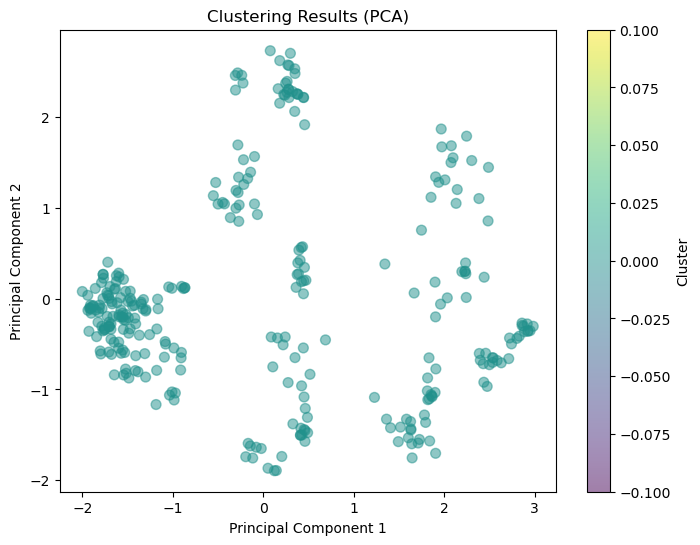

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='viridis', s=50, alpha=0.5)
plt.title('Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [9]:
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Fit the K-Modes model
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=0, random_state=42)
km.fit(X_imputed)

# Get cluster assignments from K-Modes
km_cluster_assignments = km.labels_

# Flatten the true cluster assignments
y_flat = y.values.ravel()

# Evaluate performance of K-Modes
km_ari = adjusted_rand_score(y_flat, km_cluster_assignments)
km_nmi = normalized_mutual_info_score(y_flat, km_cluster_assignments)
km_fmi = fowlkes_mallows_score(y_flat, km_cluster_assignments)

# Evaluate performance of Stochastic Bernoulli Mixture model
sbm_ari = adjusted_rand_score(y_flat, cluster_assignments)
sbm_nmi = normalized_mutual_info_score(y_flat, cluster_assignments)
sbm_fmi = fowlkes_mallows_score(y_flat, cluster_assignments)


print("Performance Comparison:")
print("K-Modes - Adjusted Rand Index (ARI):", km_ari)
print("K-Modes - Normalized Mutual Information Score (NMI):", km_nmi)
print("K-Modes - Folkes-Mallows Index (FMI):", km_fmi)
print("----------------------------------------")
print("Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI):", sbm_ari)
print("Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI):", sbm_nmi)
print("Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI):", sbm_fmi)

Performance Comparison:
K-Modes - Adjusted Rand Index (ARI): 0.16608388765264684
K-Modes - Normalized Mutual Information Score (NMI): 0.4020358135575015
K-Modes - Folkes-Mallows Index (FMI): 0.37946365260388987
----------------------------------------
Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI): 0.0
Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI): 0.0
Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI): 0.2896598585640133


$\textbf{Report Introduction}$
<br>
Clustering, a pivotal element of unsupervised learning, involves the grouping of data points based on shared characteristics or attributes. Evaluating the effectiveness of clustering algorithms in forming coherent groups is essential, facilitated by various performance metrics, each with unique strengths and limitations. This report explores three widely recognized metrics used to assess clustering performance: the Folkes-Mallows Index (FMI), the Normalized Mutual Information (NMI), and the Adjusted Rand Index (ARI), covering their rationale, advantages, disadvantages, and typical applications.

$\textbf{Adjusted Rand Index (ARI)}$:
The Adjusted Rand Index (ARI) measures the consensus between two clustering outcomes by analyzing all pairs of samples and their assigned clusters. It includes a chance adjustment to set a baseline against random cluster assignments, comparing expected similarities in random clusters with actual observed data. This adjustment ensures that ARI provides a robust evaluation, factoring in all pairs of samples and their cluster memberships.

$\textbf{Advantage}$:
- ARI quantifies the agreement between two clusterings on a scale from -1 to 1, where 1 signifies perfect concurrence.
- It is especially beneficial when verified ground truth labels are present, favored in situations where actual cluster assignments are known.

$\textbf{Disadvantage}$:
- ARI does not inherently consider the actual data labels, rendering it sensitive to variations in the number and distribution of clusters.
- The values of ARI are not restricted to positive numbers, which can complicate its interpretation due to the possibility of negative values.

$\textbf{Normalized Mutual Information (NMI)}$:
Normalized Mutual Information (NMI) evaluates the mutual dependence between true labels and predicted clusters, adjusted for chance. It offers a normalized agreement measure that spans from 0 to 1, where 1 indicates perfect agreement. NMI assesses the shared information between actual and predicted labels, with normalization ensuring that the scale of information does not skew the metric.

$\textbf{Advantage}$:
- NMI provides a normalized and symmetrical measure, easing interpretation and ensuring stability regardless of the order of true and predicted labels.
- Its symmetric property reduces bias related to data arrangement, promoting a fair evaluation of clustering performance.

$\textbf{Disadvantage}$:
- NMI may favor clusters of a uniform size, potentially neglecting the tendency of the clustering to over or under-segment.

$\textbf{Folkes-Mallows Index (FMI)}$:
The Folkes-Mallows Index (FMI) calculates the geometric mean of precision and recall concerning the true classifications, providing a balanced metric that considers both false positives and false negatives. This index offers a dual perspective on the accuracy of the clustering.

$\textbf{Advantage}$:
- FMI excels in offering a balanced assessment of precision and recall, appropriate for comprehensive evaluations of clustering outcomes.
- It considers both false positives and false negatives, providing a thorough view of the clustering’s performance and effectiveness.

$\textbf{Disadvantage}$:
- Although useful, FMI may not be as commonly employed or recognized as ARI or NMI, which may lead to lesser familiarity and usage among practitioners.

$\textbf{Report Conclusion}$
<br>
To summarize, each clustering performance metric has distinct benefits and inherent drawbacks. ARI is valuable with accessible ground truth labels, yet its effectiveness may waver based on cluster quantity and size. NMI provides a normalized measure of agreement between true labels and clustering results, though it may prefer uniformly sized clusters. Conversely, FMI delivers a balanced evaluation of both precision and recall, illuminating both false positives and false negatives. Recognizing the attributes of each metric is crucial for selecting the most suitable one according to the specific needs of the clustering task.


